In [83]:
import numpy as np
import pandas as pd
import usbtmc
from matplotlib import pyplot as plt
import struct
import time
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

class Rigol:
    """manages rigol oscilloscope"""
    def __init__(self):
         self.instr=usbtmc.Instrument(6833,1416)
         print(self.instr.ask("*IDN?"))
         print(self.instr.ask(":CHAN1:MEMD?"))

    def  retrieve(self,channel=1):
           self.instr.ask(":STOP",wait_reply=False)
           self.sample_rate=np.float(self.instr.ask(':ACQ:SAMP?'))
           print('Sample rate %f'%self.sample_rate)
           time.sleep(0.1)
           self.volt_scale=np.float(self.instr.ask(':CHAN'+str(channel)+':SCAL?'))
           print('Voltage scale is %f'%self.volt_scale)
           time.sleep(2.0)
           # for some strange reasons we are better of if we :RUN first!
           self.instr.ask(":RUN",wait_reply=False)
           raw_data=self.instr.ask_raw(bytes(":WAV:DATA? CHAN"+str(channel),'utf-8'))
           self.data=struct.unpack("B"*len(raw_data),raw_data)
           #getteing rid of meta-data
           self.data=self.data[20:-1]
           #taking caring of Rigole craziness!
           self.data=(255-np.array(self.data))*self.volt_scale/25
      
class Spectrum:
    """Manages spectrum data"""
    def __init__(self,data=[],sample_rate=1.0,max_freq=-1,peak_distance=0,file_name='spec_default',from_file=False):
        if (not from_file):
            self.sample_rate=sample_rate
            self.total_acq_time=len(data)/sample_rate
            #self.freq is the frequenct mesh
            self.freq=np.arange(0,len(data))/self.total_acq_time
            print ("min freq(precision): %f"%(self.freq[1]))
            self.min_freq=self.freq[1]
            print ("max freq: %f"%(self.freq[-1]))
            if (max_freq>0):
                self.n_max=np.int(max_freq/self.freq[1])
                self.max_freq=self.freq[self.n_max]            
            else:
                self.n_max=len(self.freq)
                self.max_freq=self.freq[-1]
            print("n_max %f"%self.n_max)
            print("max_freq %f"%self.max_freq)
            ham_mask=hamming(np.arange(0,len(data)),len(data))
            self.spec=np.fft.fft(data*ham_mask)/len(data)
            self.spec=np.abs(self.spec[2:self.n_max])
            self.freq=self.freq[2:self.n_max]
            to_file=pd.DataFrame(np.array([self.freq,self.spec*2]).T,columns=['freq(Hz)','voltage'])
            to_file.to_csv(file_name+'.csv')
        else:
            from_file=pd.read_csv(file_name+'.csv')
            self.spec=from_file['voltage'].values/2
            self.freq=from_file['freq(Hz)'].values
            self.min_freq=self.freq[1]-self.freq[0]
            self.sample_rate=1.0/self.min_freq
            self.n_max=len(self.freq)
            self.max_freq=self.freq[-1]
            
        if (peak_distance>0):
            n_distance=np.int(peak_distance/self.min_freq)+1
            print(n_distance)
            self.peaks=find_peaks(self.spec,distance=n_distance)[0]
        
            real_v=self.spec[self.peaks]*0
            for i in range(-n_distance//2-1,n_distance//2+1):
                ind=self.peaks+i
                ind[ind<0]=0
                ind[ind>len(self.spec)-1]=len(self.spec)-1
                real_v+= self.spec[ind]**2
            real_v=2*np.sqrt(real_v)
            V0=np.sqrt(0.001*50.0*2)
            self.peaks_frame=pd.DataFrame(np.array([self.freq[self.peaks],self.spec
                                   [self.peaks]*2,real_v,
                                       20*np.log10(real_v/V0)]
                                     ).T,columns=['freq(Hz)','strength','real_v','dBmW'])
            self.peaks_frame=self.peaks_frame.sort_values(by=['real_v'],ascending=False)
            self.peaks_frame['rel_freq']=self.peaks_frame['freq(Hz)']/self.peaks_frame['freq(Hz)'].iloc[0]
            self.no_peaks=False
        else:
            self.no_peaks=True
    
        self.plot()
    def plot(self,output='spec_default.png',min_freq=-1,max_freq=-1):
        if (min_freq>=0 and max_freq>=0):
            freq=self.freq[np.logical_and((self.freq>=min_freq) , (self.freq<=max_freq))]
            spec=self.spec[np.logical_and((self.freq>=min_freq) , (self.freq<=max_freq))]
        else:
            freq=self.freq
            spec=self.spec
            
        plt.plot(freq,spec*2) #*2 because we want "peak" voltages,sum of two + - freq components
        plt.xlabel('freq')
        plt.ylabel('Volt-p')
        plt.grid()
        if (not self.no_peaks):
            some_peaks=self.peaks_frame[:min(20,np.shape(self.peaks_frame)[0])]
            if (min_freq>=0 and max_freq>=0):
                some_peaks=some_peaks.loc[np.logical_and((some_peaks['freq(Hz)']>=min_freq), (some_peaks['freq(Hz)']
                                                                                  <=max_freq))]
                
            plt.plot(some_peaks['freq(Hz)'],some_peaks['strength'],'*')
        plt.savefig(output)
    
    def optimize_peak(self,width,ind=0,plot=True):
        peak=self.peaks_frame.iloc[ind]
        ind_peak=np.int(peak['freq(Hz)']//self.min_freq-2)
        ind_begin=np.int(max(0,ind_peak-width//self.min_freq-2))
        ind_end=np.int(min(ind_peak+width//self.min_freq+1-2,len(self.freq)-1))
        w=self.freq[ind_begin:ind_end]
        spd=self.spec[ind_begin:ind_end]**2
        
        
        #lorenz0=lorenz(w2,w[len(w)//2],10*self.min_freq,spd[len(spd)//2]/2)
        #plt.plot(w2/np.pi/2,np.sqrt(lorenz0),label="guessed",color='orange')
        param=curve_fit(lorenz,w,spd,[w[len(w)//2],2*self.min_freq,spd[len(spd)//2]/2],maxfev=10000)
        if (plot):
            w2=np.linspace(w[0],w[-1],101)
            lorenz2=lorenz(w2,*param[0])
            plt.bar(self.freq[ind_begin:ind_end],self.spec[ind_begin:ind_end],color='grey')
            plt.grid()
            plt.plot(w2,np.sqrt(lorenz2),label="guessed",color='red')
        out=pd.Series([param[0][0],param[0][1]],index=['freq(Hz)','width'])
        print(param[0][0],param[0][1])
        return out
    
    def optimize(self,width,number=10):
        self.opt_peak=self.peaks_frame[:number]
        for i in range(0,number):
            s=self.optimize_peak(width,i,plot=False)
            
            self.opt_peak.iloc[i]['freq(Hz)']=s['freq(Hz)']
            self.opt_peak.iloc[i]['width']=s['width']
        for i in range(0,number):
            self.opt_peak.iloc[i]['rel_freq']=self.opt_peak.iloc[i]['freq(Hz)']/self.opt_peak.iloc[0]['freq(Hz)']
                                
        return self.opt_peak    
    
    


def hamming(n,L):
    return 0.54-0.46*np.cos(2*np.pi*n/(L-1))

def lorenz(x,x0,sig,a):
    #return a*sig**2/((x-x0)**2+sig**2)
    return a*np.exp(-(x-x0)**2/2/sig**2)

In [2]:
instr=Rigol()

Rigol Technologies,DS1102E,DS1ET194510708,00.04.02.01.00
745472


In [94]:
instr.retrieve()

Sample rate 436906.656250
Voltage scale is 0.050000


1048555
min freq(precision): 0.416675
max freq: 436906.239575
n_max 4799.000000
max_freq 1999.623332
24


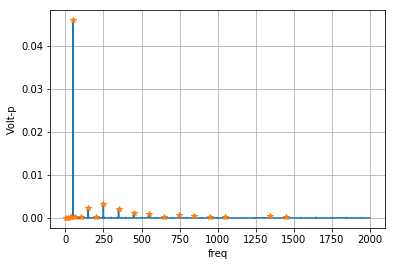

In [95]:
print(len(instr.data))
spec=Spectrum(instr.data,instr.sample_rate,2000.0,10)

48


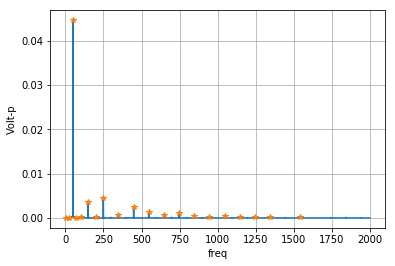

In [92]:
spec2=Spectrum(peak_distance=20,from_file=True)

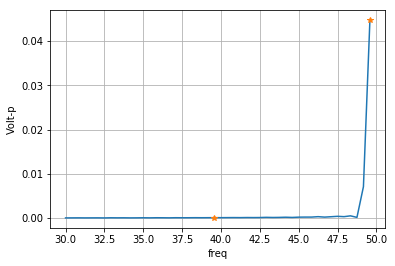

In [89]:
spec2.plot(min_freq=30,max_freq=50)

In [48]:
spec2.min_freq

0.4166750015497519

149.33098385621489 -0.21871973042788959


freq(Hz)    149.330984
width        -0.218720
dtype: float64

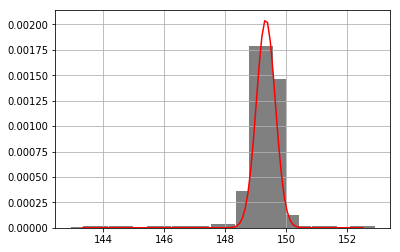

In [93]:
spec2.optimize_peak(width=5,ind=2)

In [86]:
spec2.peaks_frame[:10]

,freq(Hz),strength,real_v,dBmW,rel_freq
4,49.584325,0.044660,0.061785,-14.182366,1.000000
20,248.754976,0.004598,0.005771,-34.774717,5.016807
12,149.169651,0.003579,0.004684,-36.587149,3.008403
35,447.925627,0.002365,0.002813,-41.017784,9.033613
43,547.510952,0.001314,0.001547,-46.210857,11.042017
56,746.681603,0.001037,0.001237,-48.151591,15.058824
27,348.340301,0.000711,0.000861,-51.301246,7.025210
50,647.096277,0.000594,0.000692,-53.199376,13.050420
3,39.584125,0.000112,0.000617,-54.201079,0.798319
5,60.001200,0.000107,0.000602,-54.408433,1.210084


In [91]:
spec2.optimize(5,5)

49.77842162035862 0.21095245092553383
248.88353248752313 0.22294537065304748
149.33098385621489 -0.21871973042788959
447.97996222482567 -0.2272867329403705
547.5140292734723 0.22770936346999476


,freq(Hz),strength,real_v,dBmW,rel_freq
4,49.778422,0.044660,0.061785,-14.182366,1.000000
20,248.883532,0.004598,0.005771,-34.774717,4.999828
12,149.330984,0.003579,0.004684,-36.587149,2.999914
35,447.979962,0.002365,0.002813,-41.017784,8.999481
43,547.514029,0.001314,0.001547,-46.210857,10.999024


In [96]:
spec.peaks_frame[:5]

,freq(Hz),strength,real_v,dBmW,rel_freq
4,50.001000,0.045895,0.062878,-14.029980,1.000000
20,249.171651,0.003171,0.004183,-37.570469,4.983333
12,149.586326,0.002380,0.003116,-40.128463,2.991667
28,348.756976,0.002147,0.002894,-40.770942,6.975000
36,448.342302,0.001205,0.001747,-45.155567,8.966667


In [97]:
spec.optimize(5,5)

49.81269606558811 0.2143267351043612
249.10703787339614 0.27369748215270495
149.44992032265202 0.24134173503633982
348.78026452493583 0.2876793076392727
448.4134186982472 -0.3166292609224274


,freq(Hz),strength,real_v,dBmW,rel_freq
4,49.812696,0.045895,0.062878,-14.029980,1.000000
20,249.107038,0.003171,0.004183,-37.570469,5.000874
12,149.449920,0.002380,0.003116,-40.128463,3.000238
28,348.780265,0.002147,0.002894,-40.770942,7.001835
36,448.413419,0.001205,0.001747,-45.155567,9.001991
